In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tokenizer

     |████████████████████████████████| 77 kB 2.9 MB/s 


In [2]:
import os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score 
import pandas as pd
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.layers.recurrent import LSTM
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import nltk
nltk.download('stopwords')
from nltk import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
ROOT_DIR="/content/drive/MyDrive/TwitterSupport/"

In [4]:
df = pd.read_csv(ROOT_DIR+'dataset/labelled_airline_tweet.csv')
df.head()

,Unnamed: 0,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,token,topic_no,topic_prob,topic_desc
0,0,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"['aggressive', 'blast', 'obnoxious', 'entertai...",3,0.221675,Reschedule and Refund
1,1,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),[],3,0.214476,Reschedule and Refund
2,2,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),"['seat', 'play', 'fly']",4,0.227286,Phone and Online Booking
3,3,570282469121007616,negative,0.6842,Late Flight,0.3684,Virgin America,NaN,smartwatermelon,NaN,0,@VirginAmerica SFO-PDX schedule is still MIA.,NaN,2015-02-24 10:01:50 -0800,"palo alto, ca",Pacific Time (US & Canada),"['sfopdx', 'schedule']",3,0.259870,Reschedule and Refund
4,4,570276917301137409,negative,1.0000,Bad Flight,1.0000,Virgin America,NaN,heatherovieda,NaN,0,@VirginAmerica I flew from NYC to SFO last we...,NaN,2015-02-24 09:39:46 -0800,this place called NYC,Eastern Time (US & Canada),"['fully', 'large', 'gentleman']",3,0.193757,Reschedule and Refund


In [5]:
data = df[['topic_desc', 'text']].copy()

In [6]:
data.head()

,topic_desc,text
0,Reschedule and Refund,@VirginAmerica it's really aggressive to blast...
1,Reschedule and Refund,@VirginAmerica and it's a really big bad thing...
2,Phone and Online Booking,@VirginAmerica seriously would pay $30 a fligh...
3,Reschedule and Refund,@VirginAmerica SFO-PDX schedule is still MIA.
4,Reschedule and Refund,@VirginAmerica I flew from NYC to SFO last we...


In [7]:
pd.set_option('display.max_colwidth', -1)
data.sample(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,topic_desc,text
2543,Reschedule and Refund,@united I have received one previously on the 11th having checked. Odd as you said there was no complaint associated with my e-mail?
2359,Reschedule and Refund,@united It was quite enjoyable. 😊 \n\nExcept now he's stuck on the runway in Houston. 😕
5267,Reschedule and Refund,@USAirways you guys lost my luggage
954,Reschedule and Refund,@united why do you hate your passengers?
1807,Reschedule and Refund,@united worst AIRLINE \nBEWARE THEY DO NOT MAINTAIN THERE PLAIN \nBEEN ON THE RUNWAY THE PAST 4 HOURS!!!/


In [8]:
data['topic_desc'].value_counts()

Reschedule and Refund         6512
Baggage Issue                 1513
Phone and Online Booking      421 
Extra Charges                 268 
Delay and Customer Service    223 
Seating Preferences           153 
Reservation Issue             78  
Customer Experience           10  
Name: topic_desc, dtype: int64

In [18]:
def print_plot(index):
    example = df[df.index == index][['text','topic_desc']].values[0]
    if len(example) > 0:
        print(example[0])
        print('product:', example[1])
print_plot(10)

@VirginAmerica hi! I just bked a cool birthday trip with you, but i can't add my elevate no. cause i entered my middle name during Flight Booking Problems 😢
product: Reservation Issue


In [19]:
import re
def clean_text(txt):

    txt = txt.lower()
    txt = re.sub(r"(?<=\w)nt", "not",txt)
    txt = re.sub(r"(@\S+)", "", txt)
    txt = re.sub(r'\W', ' ', str(txt)) 
    txt = txt.translate(str.maketrans('', '', string.punctuation))
    txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt, flags=re.I)
    txt = re.sub(r"(http\S+|http)", "", txt)
    txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stopwords.words('english') ])
    txt = ''.join([i for i in txt if not i.isdigit()]).strip()
    return txt

In [11]:
print('Original Text : ',data['text'][5])  
print('Processed Text : ',clean_text(data['text'][5]))

Original Text :  @VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???
Processed Text :  first fare may three time carrier seat avail select


In [12]:
data['text'] = data['text'].apply(clean_text)

In [13]:
data['text'].values

array(['realli aggress blast obnoxi enotertainmenot guest face amp littl recours',
       'realli big bad thing',
       'serious would pay  flight seat play realli bad thing fli va', ...,
       'right cue delay',
       'leav  minut late flight warn commun unotil  minut late flight call shitti custom svc',
       'money chang flight answer phone suggest make commitmenot'],
      dtype=object)

In [24]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11306 unique tokens.


In [22]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape[1])

Shape of data tensor: 250


In [23]:
Y = pd.get_dummies(df['topic_desc']).values
print('Shape of label tensor:', Y.shape)
#8 classes
#9k training examples 

Shape of label tensor: (9178, 8)


In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8260, 250) (8260, 8)
(918, 250) (918, 8)


In [27]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[early_stopping])

Epoch 1/10
117/117 [==============================] - 288s 2s/step - loss: 1.1000 - accuracy: 0.7026 - val_loss: 0.9507 - val_accuracy: 0.7119
Epoch 2/10
117/117 [==============================] - 265s 2s/step - loss: 0.7982 - accuracy: 0.7385 - val_loss: 0.8777 - val_accuracy: 0.7082
Epoch 3/10
117/117 [==============================] - 264s 2s/step - loss: 0.5568 - accuracy: 0.8199 - val_loss: 0.8698 - val_accuracy: 0.7107
Epoch 4/10
117/117 [==============================] - 274s 2s/step - loss: 0.4014 - accuracy: 0.8675 - val_loss: 0.7850 - val_accuracy: 0.7421
Epoch 5/10
117/117 [==============================] - 278s 2s/step - loss: 0.3048 - accuracy: 0.8953 - val_loss: 0.8605 - val_accuracy: 0.7579
Epoch 6/10
117/117 [==============================] - 268s 2s/step - loss: 0.2286 - accuracy: 0.9244 - val_loss: 0.9425 - val_accuracy: 0.7240
Epoch 7/10
117/117 [==============================] - 267s 2s/step - loss: 0.1748 - accuracy: 0.9463 - val_loss: 0.9354 - val_accuracy: 0.7554

In [28]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

29/29 [==============================] - 6s 193ms/step - loss: 1.0167 - accuracy: 0.8126
Test set
  Loss: 1.017
  Accuracy: 0.813


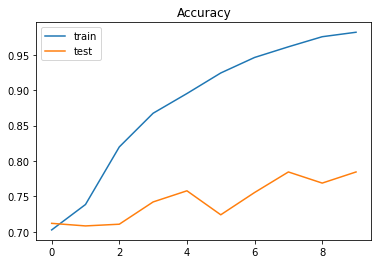

In [29]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [30]:
new_tweet = ['is todays flight from Palm Springs Ca to JFK in NY Cancelled Flightled']
seq = tokenizer.texts_to_sequences(new_tweet)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Reschedule and Refund', 'Baggage Issue','Phone and Online Booking', 'Extra Charges', 'Delay and Customer Service', 'Seating Preferences', 'Reservation Issue', 'Customer Experience']
print(pred, labels[np.argmax(pred)])

[[1.3952790e-06 8.9905922e-07 7.4816137e-07 5.6518309e-07 3.8964404e-06
  9.9998474e-01 3.0366873e-08 7.7127752e-06]] Seating Preferences


In [32]:
import pickle

model.save_weights(ROOT_DIR+"model_multiclass/multiclassComplaintClassifier.h5")

with open(ROOT_DIR+'model_multiclass/tokenizerMulticlassComplaintClassification.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
import pickle
import tensorflow.keras.models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.layers.recurrent import LSTM
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import re
from nltk.corpus import stopwords

class MulticlassComplainInference:

  def __init__(self):
      self.load_models()

  def get_model(self):
      model = Sequential()
      model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
      model.add(SpatialDropout1D(0.2))
      model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
      model.add(Dense(8, activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      return model
  
  
  def load_models(self):
      with open(ROOT_DIR+'model_multiclass/tokenizerMulticlassComplaintClassification.pickle', 'rb') as handle:
          self.tokenizer = pickle.load(handle)

      self.model = self.get_model()
      self.model.load_weights(ROOT_DIR+"model_multiclass/multiclassComplaintClassifier.h5")

  def clean_text(self, txt):

      txt = txt.lower()
      txt = re.sub(r"(?<=\w)nt", "not",txt) 
      txt = re.sub(r"(@\S+)", "", txt)  
      txt = re.sub(r'\W', ' ', str(txt)) 
      txt = txt.translate(str.maketrans('', '', string.punctuation))
      txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)   
      txt = re.sub(r'\s+', ' ', txt, flags=re.I)
      txt = re.sub(r"(http\S+|http)", "", txt)
      txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stopwords.words('english') ])
      txt = ''.join([i for i in txt if not i.isdigit()]).strip()
      return txt
  
  def predict_complaint(self, text):
      new_tweet = self.clean_text(text)
      seq = self.tokenizer.texts_to_sequences([new_tweet])
      padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
      pred = self.model.predict(padded)
      labels = ['Reschedule and Refund', 'Baggage Issue','Phone and Online Booking', 'Extra Charges', 
                'Delay and Customer Service', 'Seating Preferences', 'Reservation Issue', 'Customer Experience']
      print(pred, labels[np.argmax(pred)])
      return labels[np.argmax(pred)]


In [34]:
mul = MulticlassComplainInference()

In [37]:
mul.predict_complaint("@united I have never been mislead by a company as many times as I have this week by United Airlines!")

[[0.00172137 0.00220251 0.00400781 0.00458348 0.04309503 0.91993976
  0.00185561 0.02259446]] Seating Preferences


'Seating Preferences'